# Retrieving the Nth best redrock fit

This tutorial describes how to look up the Nth best redrock fit coefficients. 

See https://desi.lbl.gov/trac/wiki/Computing/JupyterAtNERSC to configure Jupyter at NERSC to be able to run this
tutorial using jupyter.nersc.gov and the fuji data in `/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/80618/20210328/`. This notebook runs on kernel 22.2. 

The bottom of this tutorial lists the code versions used while testing this.

Raffaella Capasso<br/>
July 2022

## Basic imports

In [28]:
import os
from astropy.table import Table
import numpy as np
import desispec.io
# import redrock.io
%pylab inline

import redrock.templates

import h5py

Populating the interactive namespace from numpy and matplotlib


Add the tutorials directory to the python search path so that we can import desitutorials

In [29]:
sys.path.append(os.path.abspath(os.getcwd()+'/../py/'))

import desitutorials

Move into the directory that contains the reference run data and set some environment variables so that desispec can find the files.  If you are running locally (*e.g.* on your laptop instead of at jupyter.nersc.gov, replace these with wherever you installed the reference run data.

In [30]:
os.chdir('/global/cfs/cdirs/desi/spectro/redux/fuji/tiles/cumulative/80618/20210328/')

Import redrock templates

In [31]:
templates = dict()
for filename in redrock.templates.find_templates():
    # print('test')
    t = redrock.templates.Template(filename) #check if you can add a "verbose=False"
    templates[(t.template_type, t.sub_type)] = t


DEBUG: Read templates from /global/common/software/desi/cori/desiconda/20211217-2.0.0/code/redrock-templates/0.7.2
DEBUG: Using default redshift range -0.0050-1.6997 for rrtemplate-galaxy.fits
DEBUG: Using default redshift range 0.0500-5.9934 for rrtemplate-qso.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-A.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-B.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-CV.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-F.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-G.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-K.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-M.fits
DEBUG: Using default redshift range -0.0020-0.0020 for rrtemplate-star-WD.fits


Read in the spectra and the matching zbest file. Also read the fibermap and trim to a unique set that row-matches the zbest file.

In [32]:
zbest = Table.read('redrock-0-80618-thru20210328.fits', hdu=1).filled('')
spectra = desispec.io.read_spectra('coadd-0-80618-thru20210328.fits')

fm = Table.read('redrock-0-80618-thru20210328.fits', hdu='FIBERMAP')
ii=sorted(np.unique(fm['TARGETID'], return_index=True)[1])
assert np.all(fm['TARGETID'] == zbest['TARGETID'])
fm = fm[ii]

INFO:spectra.py:285:read_spectra: iotime 0.410 sec to read coadd-0-80618-thru20210328.fits at 2022-07-18T01:36:25.414749


In [33]:
goodELGs = (zbest['SPECTYPE'] == 'GALAXY')  
goodELGs &= (zbest['ZWARN'] == 0)  &  (zbest['DELTACHI2']>5)
goodELGs &= (fm['OBJTYPE'] == 'TGT')

In [34]:
i = np.where(goodELGs)[0][0]
z = zbest['Z'][i]
targetid = zbest['TARGETID'][i]
spectype = zbest['SPECTYPE'][i].strip()
subtype = zbest['SUBTYPE'][i].strip()
fulltype = (spectype, subtype)
ncoeff = templates[fulltype].flux.shape[0]
coeff = zbest['COEFF'][i][0:ncoeff]

tflux = templates[fulltype].flux.T.dot(coeff)
twave = templates[fulltype].wave * (1+z)



In [37]:
print(z,targetid)

0.3149693869731157 39633023964023416


(-1.0, 8.0)

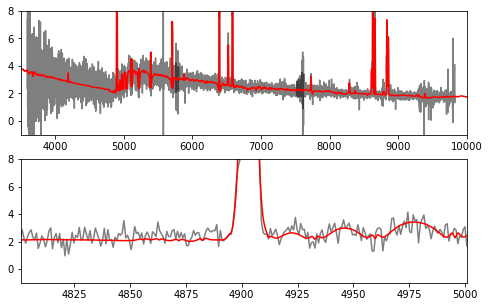

In [35]:
ispec = np.where(spectra.fibermap['TARGETID'] == targetid)[0][0]

figure(figsize=(8,5))
subplot(211)
maxflux = 0.0
for band in spectra.bands:
    plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)
    maxflux = max(maxflux, np.max(spectra.flux[band][ispec]))

plot(twave, tflux, 'r-')
xlim(3500, 10000)
# ylim(-1, 0.9*maxflux)
ylim(-1, 8)

#- zoom in on [OII]
subplot(212)
for band in spectra.bands:
    plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)

plot(twave, tflux, 'r-')
xlim(3727*(1+z)-100, 3727*(1+z)+100)
ylim(-1,8)

## Look at the best 2nd fit

In [38]:
filename = 'rrdetails-0-80618-thru20210328.h5'

data = h5py.File(filename, mode='r')
zfit = Table(np.array(data['zfit'][str(targetid)]['zfit']))
zfit['znum', 'z', 'spectype', 'zwarn', 'chi2', 'deltachi2']




rrdetails-0-80618-thru20210328.h5


znum,z,spectype,zwarn,chi2,deltachi2
int64,float64,bytes6,int64,float64,float64
0,0.3149693869731157,GALAXY,0,19333.786024093628,38410.538469314575
1,1.3150506971144742,GALAXY,0,57744.3244934082,4437.5872802734375
2,0.31481525204501165,QSO,0,62181.91177368164,19377.313468933105
3,0.7235722752431557,GALAXY,0,81559.22524261475,33740.0152888298
4,1.314497913113018,QSO,0,115299.24053144455,3688.5156153440475
5,2.0833853072073962,QSO,0,118987.7561467886,3765.731163650271
6,0.0006783307173301325,STAR,4,122753.48731043887,0.0
7,0.0002135949752383098,STAR,4,123044.96887801004,0.0
8,0.0007834616335719919,STAR,4,123931.01773693066,0.0


In [39]:
coeff_best=zfit['coeff'][0]
coeff_2nd=zfit['coeff'][1]
z_best=zfit['z'][0]
z_2nd=zfit['z'][1]


targetids = np.array(data['targetids'])
z_table = np.array(data['zscan']['GALAXY']['redshifts']) #scanned z
zchi2 = np.array(data['zscan']['GALAXY']['zchi2']) #500 targets per z
chi2_penalty = np.array(data['zscan']['GALAXY']['penalty'])


tflux_best = templates[fulltype].flux.T.dot(coeff_best)
twave_best = templates[fulltype].wave * (1+z_best)

tflux_2nd = templates[fulltype].flux.T.dot(coeff_2nd)
twave_2nd = templates[fulltype].wave * (1+z_2nd)

(-1.0, 8.0)

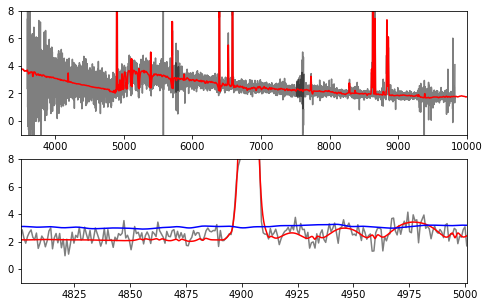

In [45]:
figure(figsize=(8,5))

ymin=-1.
ymax=8.

subplot(211)

for band in spectra.bands:
    plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)

# plot(wave, flux, 'k-', alpha=0.5)
plot(twave, tflux, 'r-')
xlim(3500, 10000)
ylim(ymin, ymax)


#- zoom in on [OII]
subplot(212)
for band in spectra.bands:
    plot(spectra.wave[band], spectra.flux[band][ispec], 'k-', alpha=0.5)

# plot(wave, flux, 'k-', alpha=0.5)
plot(twave_best, tflux_best, 'r-')
plot(twave_2nd, tflux_2nd, 'b-')
xlim(3727*(1+z)-100, 3727*(1+z)+100)
ylim(ymin, ymax)


## Code versions

In [ ]:
print('Code versions used for this tutorial:')
desitutorials.print_code_versions()